In [3]:
from utils import utils
from methods import Colors_Descriptors as C
from metrics import retrieval_distances as dist
from metrics.retrieval_metrics import *


from pathlib import Path
from typing import List
from PIL.Image import Image
from PIL import Image as Im
from skimage import filters
from scipy.signal import convolve2d
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm


from typing import *

import os
import PIL 
import cv2
import torch
import copy

import numpy as np
import matplotlib.pyplot as plt

from preprocessing.pipelines import generate_K_response


%matplotlib inline



In [4]:
        
def check_overlap(ba, bb, threshold:float=0.5):
    
    y1, x1, h1, w1 = ba
    y2, x2, h2, w2 = bb
    
    
    # Calculate the coordinates of the bounding boxes
    x1_min, y1_min, x1_max, y1_max = x1, y1, x1 + w1, y1 + h1
    x2_min, y2_min, x2_max, y2_max = x2, y2, x2 + w2, y2 + h2
    

    # Calculate the intersection area
    intersection_area = max(0, min(x1_max, x2_max) - max(x1_min, x2_min)) * \
                        max(0, min(y1_max, y2_max) - max(y1_min, y2_min))
    
    
        # Calculate areas of each bounding box
    area_bbox1 = (x1_max - x1_min) * (y1_max - y1_min)
    area_bbox2 = (x2_max - x2_min) * (y2_max - y2_min)
    
        # Calculate areas of each bounding box
    area_bbox1 = w1 * h1
    area_bbox2 = w2 * h2

    
    overlap_ratio = intersection_area / min(area_bbox1, area_bbox2)
    return overlap_ratio >= threshold

def non_maximun_supression(bboxes:list, threshold:float=0.5):
    final_voting = []
    bbox_list = copy.copy(bboxes)
    while len(bbox_list) > 0:
        current_box = bbox_list.pop(0)
        final_voting.append(current_box)
        for bbox in bbox_list:
            overlap = check_overlap(current_box[0], bbox[0])
            if overlap:
                bbox_list.remove(bbox)
                
    return final_voting


def convert2lab(img: np.ndarray):
    return (cv2.cvtColor(img, cv2.COLOR_BGR2LAB))

def convert2luv(img: np.ndarray):
    return (cv2.cvtColor(img, cv2.COLOR_BGR2LUV))


def convert2yuv(img: np.ndarray):
    return (cv2.cvtColor(img, cv2.COLOR_BGR2YUV))

def convert2hsv(img: np.ndarray):
    return (cv2.cvtColor(img, cv2.COLOR_BGR2HSV))


def convert2rg_chromaticity(img: np.ndarray) -> np.ndarray:
    """
    Convert a linear RGB image to rg chromaticity color space.

    Parameters:
        img (np.ndarray): The input linear RGB image as a NumPy array.

    Returns:
        np.ndarray: The image in rg chromaticity color space as a NumPy array.
    """
    r,g,b = cv2.split(img)
    r_c = r /(img.sum(axis=2)+1e-8)
    g_c = g /(img.sum(axis=2)+1e-8)
    b_c = np.ones_like(r_c) - r_c
    return np.dstack((r_c, g_c, b_c))


def conver2colorspace(img, colorspace=convert2lab):
    return colorspace(img)

    
def normalize(img, m=0., mx=1.):
    return cv2.normalize(img, None, m, mx, cv2.NORM_MINMAX, dtype=cv2.CV_32F)


def apply_morpholical_grad(image, kernel):
    if isinstance(kernel, tuple):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,  
                                   kernel)
        
        
    op = cv2.morphologyEx(image, cv2.MORPH_GRADIENT, kernel)
    return op

def sharpening(img):
    kernel = np.array([[0, -1, 0],
                        [-1, 10, -1],
                        [0, -1, 0]])
    sharpened = cv2.filter2D(img, -1, kernel)
    
    return sharpened


def apply_morpholical_grad(image, kernel):
    if isinstance(kernel, tuple):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,  
                                   kernel)
        
        
    op = cv2.morphologyEx(image, cv2.MORPH_GRADIENT, kernel)
    return op


def apply_open(image, kernel, iters:int=3):
    if isinstance(kernel, tuple):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,  
                                   kernel)
        
        
    op = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iters)
    return op

def apply_dilate(image, kernel, iterations:int=5):
    
    if isinstance(kernel, tuple):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,  
                                   kernel)
        
        
    op = cv2.dilate(image, kernel, iterations = iterations)
    return op

def apply_closing(image, kernel):
    if isinstance(kernel, tuple):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,  
                                   kernel)
        
    closing = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    return closing


def apply_erode(image, kernel):
    
    if isinstance(kernel, tuple):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,  
                                   kernel)
        
        
    op = cv2.erode(image, kernel)
    return op


def getGradientMagnitude(im):
    "Get magnitude of gradient for given image"
    ddepth = cv2.CV_32F
    dx = cv2.Sobel(im, ddepth, 1, 0)
    dy = cv2.Sobel(im, ddepth, 0, 1)
    dxabs = cv2.convertScaleAbs(dx)
    dyabs = cv2.convertScaleAbs(dy)
    mag = cv2.addWeighted(dxabs, 0.5, dyabs, 0.5, 0)
    return mag



def estimate_noise(I):

    H, W = I.shape

    M = [[1, -2, 1],
       [-2, 4, -2],
       [1, -2, 1]]

    sigma = np.sum(np.sum(np.absolute(convolve2d(I, M))))
    sigma = sigma * np.sqrt(0.5 * np.pi) / (6 * (W-2) * (H-2))

    return sigma


def remove_background(image):
    rgb_planes = cv2.split(image)
    result_norm_planes = []

    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7, 7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        result_norm_planes.append(norm_img)

    enhanced = cv2.merge(result_norm_planes)
    return enhanced


def CDenoissing(image):
    
    (r, g, b) = cv2.split(image)

    b_blur = cv2.medianBlur(b, 3)
    g_blur = cv2.medianBlur(g, 3)
    r_blur = cv2.medianBlur(r, 3)

    b_denoise = cv2.fastNlMeansDenoising(b_blur, 5, 9, 21)
    g_denoise = cv2.fastNlMeansDenoising(g_blur, 5, 9, 21)
    r_denoise = cv2.fastNlMeansDenoising(r_blur, 5, 9, 21)

    enhanced = cv2.merge((r_denoise, g_denoise, b_denoise))
    
    
    return enhanced

def showimage(myimage, figsize=[10,10]):
    if (myimage.ndim>2):  #This only applies to RGB or RGBA images (e.g. not to Black and White images)
        myimage = myimage[:,:,::-1] #OpenCV follows BGR order, while matplotlib likely follows RGB order
         
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(myimage, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()
    
def create_gaborfilter():
    # This function is designed to produce a set of GaborFilters 
    # an even distribution of theta values equally distributed amongst pi rad / 180 degree
     
    filters = []
    num_filters = 16
    ksize = 35  # The local area to evaluate
    sigma = 3.0  # Larger Values produce more edges
    lambd = 10.0
    gamma = 0.5
    psi = 0  # Offset value - lower generates cleaner results
    for theta in np.arange(0, np.pi, np.pi / num_filters):  # Theta is the orientation for edge detection
        kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_64F)
        kern /= 1.0 * kern.sum()  # Brightness normalization
        filters.append(kern)
    return filters

def apply_filter(img, filters):
# This general function is designed to apply filters to our image
     
    # First create a numpy array the same size as our input image
    newimage = np.zeros_like(img)
     
    # Starting with a blank image, we loop through the images and apply our Gabor Filter
    # On each iteration, we take the highest value (super impose), until we have the max value across all filters
    # The final image is returned
    depth = -1 # remain depth same as original image
     
    for kern in filters:  # Loop through the kernels in our GaborFilter
        image_filter = cv2.filter2D(img, depth, kern)  #Apply filter to image
         
        # Using Numpy.maximum to compare our filter and cumulative image, taking the higher value (max)
        np.maximum(newimage, image_filter, newimage)
    return newimage

In [5]:
def get_piramidal_histogram_descriptor(img: np.array, steps:int=5, **kwargs):
    histogram_descriptor = np.array([])
    for s in range(steps):
        tiles = 2**s
        feature_s = get_multi_tile_histogram_descriptor_grayscale(img=img, tiles=tiles, **kwargs)
        histogram_descriptor = np.concatenate((histogram_descriptor, feature_s), axis=-1)

    return histogram_descriptor


def get_multi_tile_histogram_descriptor_grayscale(img: np.array, tiles:int=10, **kwargs):
    """
    Compute a multi-tile histogram descriptor for the given image.

    Parameters:
        img (np.array): Input image.
        tiles (int): Number of tiles to divide the image into. Default is 10.
        channel (int): Channel to compute the histogram for. Default is 1.
        **kwargs: Additional keyword arguments for np.histogram.

    Returns:
        list: List of histograms for each tile.
    """

    h,w = img.shape
    feature = np.array([])
    k_size_i = img.shape[0]//tiles
    k_size_j = img.shape[1]//tiles
    for i in range(0, h - (h%tiles), k_size_i):
        for j in range(0, w - (w%tiles), k_size_j):
            hist, _ = np.histogram(img[i:i+k_size_i, j:j+k_size_j].flatten(), bins=2)
            feature = np.concatenate((feature,(hist/np.sum(hist)).flatten()), axis=-1)

    return feature

In [7]:
BBDD =  sorted(utils.read_bbdd(Path("../data/qsd1_w3")))
print(BBDD)

[WindowsPath('../data/qsd1_w3/00000.jpg'), WindowsPath('../data/qsd1_w3/00001.jpg'), WindowsPath('../data/qsd1_w3/00002.jpg'), WindowsPath('../data/qsd1_w3/00003.jpg'), WindowsPath('../data/qsd1_w3/00004.jpg'), WindowsPath('../data/qsd1_w3/00005.jpg'), WindowsPath('../data/qsd1_w3/00006.jpg'), WindowsPath('../data/qsd1_w3/00007.jpg'), WindowsPath('../data/qsd1_w3/00008.jpg'), WindowsPath('../data/qsd1_w3/00009.jpg'), WindowsPath('../data/qsd1_w3/00010.jpg'), WindowsPath('../data/qsd1_w3/00011.jpg'), WindowsPath('../data/qsd1_w3/00012.jpg'), WindowsPath('../data/qsd1_w3/00013.jpg'), WindowsPath('../data/qsd1_w3/00014.jpg'), WindowsPath('../data/qsd1_w3/00015.jpg'), WindowsPath('../data/qsd1_w3/00016.jpg'), WindowsPath('../data/qsd1_w3/00017.jpg'), WindowsPath('../data/qsd1_w3/00018.jpg'), WindowsPath('../data/qsd1_w3/00019.jpg'), WindowsPath('../data/qsd1_w3/00020.jpg'), WindowsPath('../data/qsd1_w3/00021.jpg'), WindowsPath('../data/qsd1_w3/00022.jpg'), WindowsPath('../data/qsd1_w3/0002

In [30]:
paints = utils.read_pickle(filepath="./painting_extraction_qsd2_w3.pkl")

In [33]:
myimage = paints[0]["result"][0]

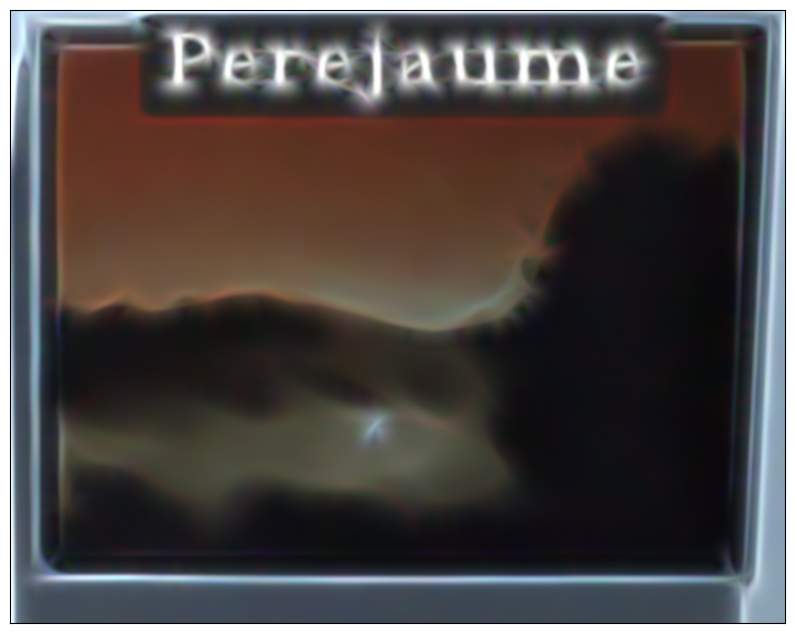

In [34]:
# We create our gabor filters, and then apply them to our image
gfilters = create_gaborfilter()
image_g = apply_filter(myimage, gfilters)

showimage(image_g)

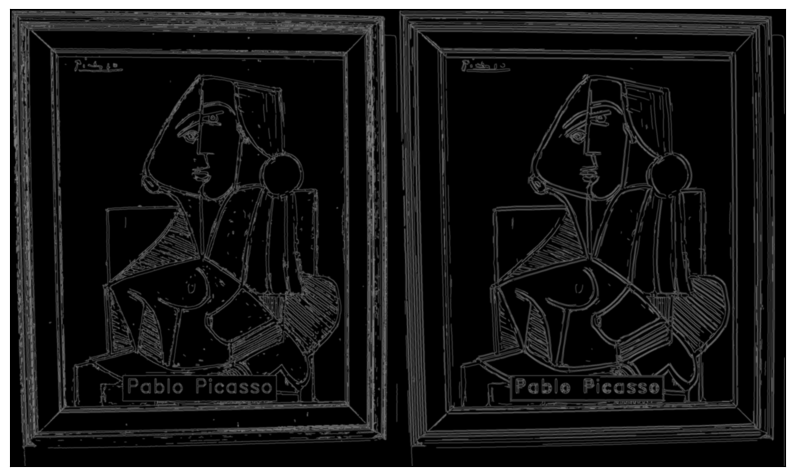

In [278]:
min_interval = 100
max_interval = 150
image_edge = cv2.Canny(myimage,min_interval,max_interval)
image_edge_g = cv2.Canny(image_g,min_interval,max_interval)
 
# Using Numpy's function to append the two images horizontally
side_by_side = np.hstack((image_edge,image_edge_g))
showimage(side_by_side,[10,10])

## QSD2 extraction

In [279]:
min_interval = 100
max_interval = 150
for idx, info in tqdm(paints.items()):
    gabor_imgs = []
    gabor_descriptors = []
    list_img = info["result"]
    for paint in list_img:
        gabor_filter_img = apply_filter(paint, gfilters)
        image_edge_g = cv2.Canny(gabor_filter_img, min_interval, max_interval)
        

        gabor_imgs.append(gabor_filter_img)
        final_im = final_image(gabor_filter_img)
        image_edge_g = cv2.Canny(final_im, min_interval, max_interval)

        
        descriptor = get_piramidal_histogram_descriptor(img=image_edge_g, steps=4)
        gabor_descriptors.append(descriptor)
        
    info["texture_descriptors"] = gabor_descriptors
    info["texture_result"] = gabor_imgs
        
    

100%|███████████████████████████████████████████| 30/30 [00:26<00:00,  1.13it/s]


In [18]:
def generate_texture_histogram_descriptors(imgs:List[np.ndarray], **kwargs):
    """
    Generate grayscale histogram descriptors for a list of images.

    Parameters:
        imgs (List[np.ndarray]): List of input images.
        **kwargs: Additional keyword arguments for CD.get_grayscale_histogram_descriptor.

    Returns:
        Dict[int, np.ndarray]: Dictionary of grayscale histogram descriptors for each image.
    """
    
    min_interval = 0
    max_interval = 100
    
    descriptors = {idx:{} for idx in range(len(imgs))}
    for idx, img in tqdm(enumerate(imgs)):
    
        image = cv2.imread(str(img))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        gray_image = (cv2.cvtColor(image, cv2.COLOR_RGB2GRAY))
        if estimate_noise(gray_image) > 1:
            image = CDenoissing(image) 
            
        gabor_filter_img = apply_filter(image, gfilters)
        image_edge_g = cv2.Canny(gabor_filter_img,min_interval,max_interval)

        descriptor = get_piramidal_histogram_descriptor(img=image_edge_g, steps=4)

        descriptors[idx]["texture_descriptors"] = descriptor
        descriptors[idx]["name"] = img.name
        descriptors[idx]["texture_result"] = gabor_filter_img

    return descriptors

## QSD1_w3 test

In [8]:
BBDD_query = sorted(utils.read_bbdd(Path("../data/qsd1_w3")))
print(BBDD_query)

[WindowsPath('../data/qsd1_w3/00000.jpg'), WindowsPath('../data/qsd1_w3/00001.jpg'), WindowsPath('../data/qsd1_w3/00002.jpg'), WindowsPath('../data/qsd1_w3/00003.jpg'), WindowsPath('../data/qsd1_w3/00004.jpg'), WindowsPath('../data/qsd1_w3/00005.jpg'), WindowsPath('../data/qsd1_w3/00006.jpg'), WindowsPath('../data/qsd1_w3/00007.jpg'), WindowsPath('../data/qsd1_w3/00008.jpg'), WindowsPath('../data/qsd1_w3/00009.jpg'), WindowsPath('../data/qsd1_w3/00010.jpg'), WindowsPath('../data/qsd1_w3/00011.jpg'), WindowsPath('../data/qsd1_w3/00012.jpg'), WindowsPath('../data/qsd1_w3/00013.jpg'), WindowsPath('../data/qsd1_w3/00014.jpg'), WindowsPath('../data/qsd1_w3/00015.jpg'), WindowsPath('../data/qsd1_w3/00016.jpg'), WindowsPath('../data/qsd1_w3/00017.jpg'), WindowsPath('../data/qsd1_w3/00018.jpg'), WindowsPath('../data/qsd1_w3/00019.jpg'), WindowsPath('../data/qsd1_w3/00020.jpg'), WindowsPath('../data/qsd1_w3/00021.jpg'), WindowsPath('../data/qsd1_w3/00022.jpg'), WindowsPath('../data/qsd1_w3/0002

In [9]:
OBBDD = sorted(utils.read_bbdd(Path("../data/BBDD")))
print(OBBDD)

[WindowsPath('../data/BBDD/bbdd_00000.jpg'), WindowsPath('../data/BBDD/bbdd_00001.jpg'), WindowsPath('../data/BBDD/bbdd_00002.jpg'), WindowsPath('../data/BBDD/bbdd_00003.jpg'), WindowsPath('../data/BBDD/bbdd_00004.jpg'), WindowsPath('../data/BBDD/bbdd_00005.jpg'), WindowsPath('../data/BBDD/bbdd_00006.jpg'), WindowsPath('../data/BBDD/bbdd_00007.jpg'), WindowsPath('../data/BBDD/bbdd_00008.jpg'), WindowsPath('../data/BBDD/bbdd_00009.jpg'), WindowsPath('../data/BBDD/bbdd_00010.jpg'), WindowsPath('../data/BBDD/bbdd_00011.jpg'), WindowsPath('../data/BBDD/bbdd_00012.jpg'), WindowsPath('../data/BBDD/bbdd_00013.jpg'), WindowsPath('../data/BBDD/bbdd_00014.jpg'), WindowsPath('../data/BBDD/bbdd_00015.jpg'), WindowsPath('../data/BBDD/bbdd_00016.jpg'), WindowsPath('../data/BBDD/bbdd_00017.jpg'), WindowsPath('../data/BBDD/bbdd_00018.jpg'), WindowsPath('../data/BBDD/bbdd_00019.jpg'), WindowsPath('../data/BBDD/bbdd_00020.jpg'), WindowsPath('../data/BBDD/bbdd_00021.jpg'), WindowsPath('../data/BBDD/bbdd_

In [13]:
querys_gt = utils.read_pickle("../data/qsd1_w3/gt_corresps.pkl")
gt = [value[0] for value in querys_gt]
print(querys_gt)

[[92], [262], [260], [13], [212], [180], [94], [100], [280], [113], [211], [6], [236], [277], [182], [25], [90], [193], [286], [155], [272], [258], [219], [7], [35], [155], [21], [251], [22], [32]]


In [19]:
descriptors_query = generate_texture_histogram_descriptors(imgs=BBDD_query)

30it [01:26,  2.88s/it]


In [20]:
descriptors_BBDD = generate_texture_histogram_descriptors(imgs=OBBDD)

287it [36:39,  7.67s/it]


In [92]:
a = copy.copy(descriptors_BBDD[92]["texture_descriptors"])
b = copy.copy(descriptors_query[0]["texture_descriptors"])
dist.hellkdis(a, b)

83.26002490292092

In [21]:
def retriev_image(descriptors_bdr:Dict[str, np.ndarray], compare_descriptor: np.ndarray, distance:Callable) -> List[Tuple[float, str]]:
    """
    Retrieve images based on a similarity measure between descriptors.

    This function compares a given descriptor against a collection of descriptors and returns a sorted list of tuples
    representing the similarity scores and corresponding image names.

    Parameters:
    - descriptors_bdr (Dict[str, np.ndarray]): A dictionary mapping image names to their respective descriptors.
    - compare_descriptor (np.ndarray): The descriptor to compare against the collection of descriptors.
    - distance (Callable): A callable distance function to measure similarity between descriptors.

    Returns:
    - List[Tuple[float, str]]: A list of tuples, each containing a similarity score (between 0 and 1) and the image name.
      The list is sorted in descending order of similarity scores.
    """

    ## Have into account that we are assuming normlaized similarity where 1 is the maximun value
    results = []
    for (idx, info) in (descriptors_bdr.items()):
        descriptor = info["texture_descriptors"]
        result =  distance(descriptor, compare_descriptor)
        results.append(tuple([result, idx]))

    final = sorted(results, reverse=True)
    
    return final
    
def generate_K_response(descriptors_bdr:Dict[str, np.ndarray],
                      descriptors_queries:Dict[str, np.ndarray],
                      sim_func: Callable,
                      k:int = 1):
    """
    Generate K responses for each query descriptor using a similarity function.

    Parameters:
        descriptors_bdr (Dict[str, np.ndarray]): Dictionary of descriptors for the database images.
        descriptors_queries (Dict[str, np.ndarray]): Dictionary of descriptors for the query images.
        sim_func (Callable): Similarity function to compute the similarity between descriptors.
        k (int): Number of responses to generate for each query. Default is 1.

    Returns:
        List[List[int]]: List of K responses for each query descriptor.
    """
    
    final_responses = []
    for _,(idx, info) in enumerate((descriptors_queries.items())):
        for descriptor in info["texture_descriptors"]:
            scoring_list = (retriev_image(descriptors_bdr, descriptor, distance=sim_func))
            final_responses.append([ind[1] for ind in scoring_list[:k]])

    return final_responses

In [22]:
responses_qsd1 = generate_K_response(descriptors_bdr=descriptors_BBDD, descriptors_queries=descriptors_query, sim_func=dist.histogram_intersection, k=10)

In [125]:
responses

[[92, 133, 219, 281, 110, 153, 254, 246, 240, 124],
 [262, 235, 170, 30, 239, 142, 172, 39, 115, 174],
 [260, 25, 99, 167, 285, 60, 37, 101, 163, 30],
 [13, 145, 115, 91, 30, 78, 37, 251, 129, 163],
 [212, 40, 175, 120, 183, 150, 42, 85, 14, 224],
 [180, 172, 177, 233, 221, 174, 105, 107, 74, 235],
 [255, 142, 88, 242, 281, 31, 157, 57, 239, 136],
 [100, 251, 194, 119, 205, 248, 48, 19, 261, 112],
 [278, 16, 1, 280, 232, 186, 270, 165, 93, 24],
 [142, 88, 113, 31, 39, 259, 255, 57, 281, 239],
 [211, 81, 205, 251, 248, 52, 137, 12, 93, 14],
 [240, 216, 110, 157, 139, 254, 74, 6, 281, 264],
 [225, 261, 60, 29, 30, 251, 195, 244, 215, 194],
 [277, 106, 250, 3, 206, 181, 224, 14, 283, 116],
 [181, 40, 56, 116, 224, 1, 120, 270, 182, 191],
 [25, 60, 99, 104, 163, 30, 167, 122, 243, 249],
 [205, 19, 29, 60, 43, 251, 30, 25, 248, 195],
 [193, 12, 265, 161, 243, 104, 25, 61, 245, 89],
 [286, 142, 37, 121, 259, 104, 32, 242, 9, 122],
 [155, 218, 9, 37, 246, 144, 122, 27, 142, 82],
 [272, 58, 18

In [23]:
print(mapk(querys_gt, responses_qsd1, k=1))
print(mapk(querys_gt, responses_qsd1, k=5))
print(mapk(querys_gt, responses_qsd1, k=10))


0.0
0.0
0.0


In [38]:
querys_gt = utils.read_pickle("../data/qsd2_w3/gt_corresps.pkl")
gt = [value[0] for value in querys_gt]
print(querys_gt)

[[282], [116, 147], [184, 182], [225], [161, 193], [53], [113], [104, 130], [41], [192, 259], [238], [248], [241], [58], [203], [128], [260], [107, 164], [189], [81, 163], [25], [132, 237], [286], [200], [251], [35], [219, 179], [76], [183], [104]]


In [40]:
gt = [[value] for sublist in querys_gt for value in sublist]
gt

[[282],
 [116],
 [147],
 [184],
 [182],
 [225],
 [161],
 [193],
 [53],
 [113],
 [104],
 [130],
 [41],
 [192],
 [259],
 [238],
 [248],
 [241],
 [58],
 [203],
 [128],
 [260],
 [107],
 [164],
 [189],
 [81],
 [163],
 [25],
 [132],
 [237],
 [286],
 [200],
 [251],
 [35],
 [219],
 [179],
 [76],
 [183],
 [104]]

## QSD2_w3 test

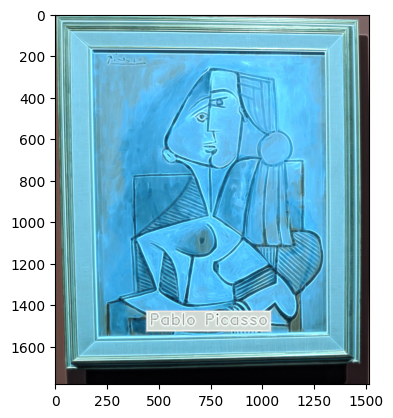

In [199]:
plt.imshow(paints[1]["texture_result"][0])

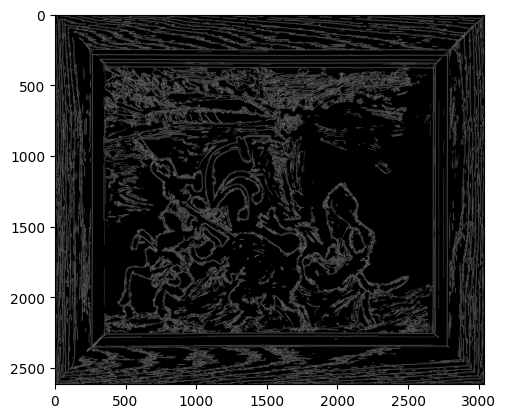

In [220]:
image_edge_ggg = cv2.Canny(descriptors_BBDD[147]["texture_result"],50,75)
plt.imshow(image_edge_ggg, cmap="gray")

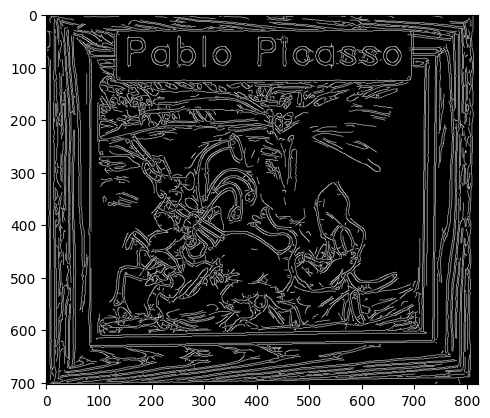

In [265]:
image_edge_ggg = cv2.Canny(paints[1]["texture_result"][1], 75,150)
plt.imshow(final_image(image_edge_ggg), cmap="gray")

In [251]:
def final_image(img):
    ss =apply_closing(image_edge_ggg, (10,10))
    ss = apply_erode(ss, (3,3))
    ## Get the center of the image
    contours, hierarchy = cv2.findContours(ss, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    decission = []
    heigh_im, width_im = ss.shape

    area_total = heigh_im * width_im


    for contour in contours:
        convexHull = cv2.convexHull(contour)

        perimeter = cv2.arcLength(convexHull, True)
        x,y,w,h = cv2.boundingRect(convexHull)
        aspect_ratio = w/h
        area = w*h
        proportion_height =  h/heigh_im
        proportion_width = w / width_im

        if (proportion_height  > 0.15) and (proportion_width > 0.15) and width_im :
            decission.append(([y,x,h,w], perimeter, area ,aspect_ratio))


    decission = sorted(decission, key=lambda x: x[2], reverse=True)
    decission = non_maximun_supression(decission)
    y,x,h,w = decission[0][0]
    
    return img[y:y+h, x:x+w]

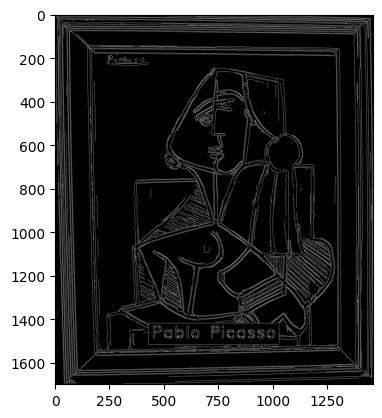

In [252]:

plt.imshow(final_image(image_edge_ggg), cmap="gray")

In [258]:
dist.jensensim(descriptors_BBDD[104]["texture_descriptors"], paints[29]["texture_descriptors"][0])

0.6995355328485676

In [171]:
paints[0]["texture_descriptors"][0]

array([0.94648327, 0.05351673, 0.92409803, 0.07590197, 0.92818244,
       0.07181756, 0.96739765, 0.03260235, 0.96625498, 0.03374502,
       0.88709521, 0.11290479, 0.885053  , 0.114947  , 0.8943888 ,
       0.1056112 , 0.9033356 , 0.0966644 , 0.93960906, 0.06039094,
       0.98463483, 0.01536517, 0.96761645, 0.03238355, 0.94738889,
       0.05261111, 0.9565302 , 0.0434698 , 0.99319265, 0.00680735,
       0.99426237, 0.00573763, 0.94758339, 0.05241661, 0.94184576,
       0.05815424, 0.97802198, 0.02197802, 0.97802198, 0.02197802,
       0.94515219, 0.05484781, 0.83253968, 0.16746032, 0.84444444,
       0.15555556, 0.83293651, 0.16706349, 0.83134921, 0.16865079,
       0.83928571, 0.16071429, 0.84444444, 0.15555556, 0.86984127,
       0.13015873, 0.87142857, 0.12857143, 0.91626984, 0.08373016,
       0.9515873 , 0.0484127 , 0.94365079, 0.05634921, 0.92857143,
       0.07142857, 0.94801587, 0.05198413, 0.94166667, 0.05833333,
       0.96865079, 0.03134921, 0.91428571, 0.08571429, 0.92063

In [281]:
responses_qsd2 = generate_K_response(descriptors_bdr=descriptors_BBDD, descriptors_queries=paints, sim_func=dist.histogram_intersection, k=10)

In [282]:
print(responses_qsd2)

[[247, 219, 240, 133, 246, 282, 53, 229, 180, 46], [57, 110, 216, 46, 62, 157, 255, 124, 82, 282], [110, 255, 57, 281, 157, 46, 88, 216, 246, 31], [139, 173, 274, 254, 184, 282, 246, 199, 34, 219], [157, 33, 74, 110, 281, 57, 216, 6, 174, 153], [110, 255, 57, 216, 240, 223, 254, 88, 153, 281], [110, 57, 255, 216, 153, 281, 240, 223, 157, 254], [282, 173, 199, 276, 274, 110, 28, 171, 22, 62], [274, 247, 22, 199, 48, 271, 238, 62, 11, 231], [110, 57, 216, 254, 240, 255, 223, 153, 281, 157], [187, 110, 57, 240, 276, 227, 254, 9, 17, 223], [57, 110, 216, 255, 46, 157, 254, 281, 240, 153], [110, 254, 57, 216, 240, 223, 255, 153, 139, 157], [110, 216, 57, 254, 240, 153, 255, 281, 223, 157], [110, 153, 255, 57, 33, 74, 216, 223, 46, 281], [13, 267, 207, 226, 280, 199, 34, 106, 89, 193], [110, 57, 255, 216, 88, 240, 281, 31, 223, 46], [110, 254, 216, 227, 240, 139, 246, 17, 153, 57], [110, 57, 255, 216, 240, 281, 153, 254, 88, 223], [110, 57, 216, 255, 240, 223, 153, 281, 254, 31], [110, 254, 

In [269]:
querys_gt

[[282],
 [116, 147],
 [184, 182],
 [225],
 [161, 193],
 [53],
 [113],
 [104, 130],
 [41],
 [192, 259],
 [238],
 [248],
 [241],
 [58],
 [203],
 [128],
 [260],
 [107, 164],
 [189],
 [81, 163],
 [25],
 [132, 237],
 [286],
 [200],
 [251],
 [35],
 [219, 179],
 [76],
 [183],
 [104]]

# Combined texture and color descriptors

In [24]:
def get_piramidal_color_descriptor(img: np.array, steps:int=5, **kwargs):
    histogram_descriptor = np.array([])
    for s in range(steps):
        tiles = 2**s
        feature_s = get_multi_tile_histogram_descriptor(img=img, tiles=tiles, **kwargs)
        histogram_descriptor = np.concatenate((histogram_descriptor, feature_s), axis=-1)

    return histogram_descriptor


def get_multi_tile_histogram_descriptor(img: np.array, tiles:int=10, **kwargs):
    """
    Compute a multi-tile histogram descriptor for the given image.

    Parameters:
        img (np.array): Input image.
        tiles (int): Number of tiles to divide the image into. Default is 10.
        channel (int): Channel to compute the histogram for. Default is 1.
        **kwargs: Additional keyword arguments for np.histogram.

    Returns:
        list: List of histograms for each tile.
    """

    h,w, channels = img.shape
    feature = np.array([])
    k_size_i = img.shape[0]//tiles
    k_size_j = img.shape[1]//tiles
    for i in range(0, h - (h%tiles), k_size_i):
        for j in range(0, w - (w%tiles), k_size_j):
            hist, _, _ = np.histogram2d(img[i:i+k_size_i, j:j+k_size_j, 1].flatten(), img[i:i+k_size_i, j:j+k_size_j, 2].flatten(), **kwargs)
            feature = np.concatenate((feature,(hist/np.sum(hist)).flatten()), axis=-1)

    return feature

def generate_combined_descriptors(imgs:List[np.ndarray], **kwargs):
    """
    Generate grayscale histogram descriptors for a list of images.

    Parameters:
        imgs (List[np.ndarray]): List of input images.
        **kwargs: Additional keyword arguments for CD.get_grayscale_histogram_descriptor.

    Returns:
        Dict[int, np.ndarray]: Dictionary of grayscale histogram descriptors for each image.
    """
    
    min_interval = 0
    max_interval = 100
    
    descriptors = {idx:{} for idx in range(len(imgs))}
    for idx, img in tqdm(enumerate(imgs)):
    
        image = cv2.imread(str(img))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        gray_image = (cv2.cvtColor(image, cv2.COLOR_RGB2GRAY))
        if estimate_noise(gray_image) > 1:
            image = CDenoissing(image) 
            
        gabor_filter_img = apply_filter(image, gfilters)
        image_edge_g = cv2.Canny(gabor_filter_img,min_interval,max_interval)

        descriptor = get_piramidal_histogram_descriptor(img=image_edge_g, steps=4)

        image = convert2lab(image)
        color_descriptor = get_piramidal_color_descriptor(img=image, steps = 4)

        descriptors[idx]["combined_descriptor"] = np.concatenate((descriptor, color_descriptor))
        descriptors[idx]["name"] = img.name
        descriptors[idx]["texture_result"] = gabor_filter_img

    return descriptors

In [25]:
descriptors_c_query = generate_combined_descriptors(imgs=BBDD_query)

30it [01:23,  2.80s/it]


In [26]:
descriptors_c_BBDD = generate_combined_descriptors(imgs=OBBDD)

287it [37:48,  7.90s/it]


In [29]:
def retriev_image(descriptors_bdr:Dict[str, np.ndarray], compare_descriptor: np.ndarray, distance:Callable) -> List[Tuple[float, str]]:
    """
    Retrieve images based on a similarity measure between descriptors.

    This function compares a given descriptor against a collection of descriptors and returns a sorted list of tuples
    representing the similarity scores and corresponding image names.

    Parameters:
    - descriptors_bdr (Dict[str, np.ndarray]): A dictionary mapping image names to their respective descriptors.
    - compare_descriptor (np.ndarray): The descriptor to compare against the collection of descriptors.
    - distance (Callable): A callable distance function to measure similarity between descriptors.

    Returns:
    - List[Tuple[float, str]]: A list of tuples, each containing a similarity score (between 0 and 1) and the image name.
      The list is sorted in descending order of similarity scores.
    """

    ## Have into account that we are assuming normlaized similarity where 1 is the maximun value
    results = []
    for (idx, info) in (descriptors_bdr.items()):
        descriptor = info["combined_descriptor"]
        result =  distance(descriptor, compare_descriptor)
        results.append(tuple([result, idx]))

    final = sorted(results, reverse=True)
    
    return final

def generate_K_response(descriptors_bdr:Dict[str, np.ndarray],
                      descriptors_queries:Dict[str, np.ndarray],
                      sim_func: Callable,
                      k:int = 1):
    """
    Generate K responses for each query descriptor using a similarity function.

    Parameters:
        descriptors_bdr (Dict[str, np.ndarray]): Dictionary of descriptors for the database images.
        descriptors_queries (Dict[str, np.ndarray]): Dictionary of descriptors for the query images.
        sim_func (Callable): Similarity function to compute the similarity between descriptors.
        k (int): Number of responses to generate for each query. Default is 1.

    Returns:
        List[List[int]]: List of K responses for each query descriptor.
    """
    
    final_responses = []
    for _,(idx, info) in enumerate((descriptors_queries.items())):
        for descriptor in info["combined_descriptor"]:
            scoring_list = (retriev_image(descriptors_bdr, descriptor, distance=sim_func))
            final_responses.append([ind[1] for ind in scoring_list[:k]])

    return final_responses

responses_qsd1 = generate_K_response(descriptors_bdr=descriptors_c_BBDD, descriptors_queries=descriptors_c_query, sim_func=dist.histogram_intersection, k=10)
print(mapk(querys_gt, responses_qsd1, k=1))
print(mapk(querys_gt, responses_qsd1, k=5))
print(mapk(querys_gt, responses_qsd1, k=10))

KeyboardInterrupt: 